# Task 1 – Huffman Encoding and Information Representation

 
**Message used:** `PHOTOSYNTHESIS`

### Goal
Demonstrate how Huffman coding represents information efficiently by building a variable-length code for a short message, showing the tree, computing codes, encoding the message, and reflecting on results.

## 1 — Character frequencies

First we count how often each character appears in the message. This frequency table is the starting point for the Huffman algorithm.


In [1]:
from collections import Counter
text = "PHOTOSYNTHESIS"
freq = Counter(text)
print('Message:', text)
print('\nFrequencies:')
for ch, f in sorted(freq.items()):
    print(f"  {ch}: {f}")


Message: PHOTOSYNTHESIS

Frequencies:
  E: 1
  H: 2
  I: 1
  N: 1
  O: 2
  P: 1
  S: 3
  T: 2
  Y: 1


## 2 — Build the Huffman tree

We use a priority queue (min-heap). At each step we remove the two least-frequent nodes, combine them into a new node whose frequency is the sum, and push that node back. Ties are broken deterministically (alphabetical order) so the output is repeatable.


In [2]:
import heapq
from collections import namedtuple

class Node(namedtuple('Node', ['char', 'freq', 'left', 'right'])):
    def __lt__(self, other):
        # deterministic tie-breaker: smaller freq first, then by character string
        if self.freq != other.freq:
            return self.freq < other.freq
        return (self.char or '') < (other.char or '')

def build_huffman_tree(text):
    freq = Counter(text)
    heap = [Node(ch, f, None, None) for ch, f in freq.items()]
    heapq.heapify(heap)
    steps = []
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        combined = Node(None, left.freq + right.freq, left, right)
        heapq.heappush(heap, combined)
        steps.append(((left.char, left.freq), (right.char, right.freq), combined.freq))
    return heap[0], steps

tree, combine_steps = build_huffman_tree(text)
print('Combination steps (two popped -> new node freq):')
for a,b,c in combine_steps:
    print(f'  pop {a} and {b} -> push (None, {c})')


Combination steps (two popped -> new node freq):
  pop ('E', 1) and ('I', 1) -> push (None, 2)
  pop ('N', 1) and ('P', 1) -> push (None, 2)
  pop ('Y', 1) and (None, 2) -> push (None, 3)
  pop (None, 2) and ('H', 2) -> push (None, 4)
  pop ('O', 2) and ('T', 2) -> push (None, 4)
  pop (None, 3) and ('S', 3) -> push (None, 6)
  pop (None, 4) and (None, 4) -> push (None, 8)
  pop (None, 6) and (None, 8) -> push (None, 14)


## 3 — Print the tree (centered) and show codes

We print the tree in a centered (pyramid) layout for readability, then extract the Huffman codes by walking the tree (left=0, right=1).

In [3]:
def get_all_chars(node):
    if node is None:
        return []
    if node.char:
        return [node.char]
    return get_all_chars(node.left) + get_all_chars(node.right)

def node_label(node):
    if node is None:
        return ''
    if node.char:
        return f"{node.char}({node.freq})"
    chars = ''.join(sorted(get_all_chars(node)))
    return f"[{chars}:{node.freq}]"

def get_levels(root):
    levels = []
    this = [root]
    while any(this):
        levels.append(this)
        nxt = []
        for n in this:
            if n:
                nxt.append(n.left)
                nxt.append(n.right)
            else:
                nxt.extend([None, None])
        this = nxt
    return levels

def print_centered_tree(root, width=76):
    levels = get_levels(root)
    for i, level in enumerate(levels):
        slot = max(1, width // (2**i))
        line = ''.join((node_label(n) if n else '').center(slot) for n in level)
        print(line.rstrip())
        print()

print('\nHuffman Tree (centered):')
print_centered_tree(tree)

def get_codes(node, prefix='', codes=None):
    if codes is None:
        codes = {}
    if node is None:
        return codes
    if node.char:
        codes[node.char] = prefix or '0'
    else:
        get_codes(node.left, prefix + '0', codes)
        get_codes(node.right, prefix + '1', codes)
    return codes

codes = get_codes(tree)
print('Huffman Codes:')
for ch in sorted(codes):
    print(f'  {ch}: {codes[ch]}')



Huffman Tree (centered):
                               [EHINOPSTY:14]

               [NPSY:6]                             [EHIOT:8]

      [NPY:3]              S(3)             [EHI:4]             [OT:4]

   Y(1)    [NP:2]                     [EI:2]    H(2)     O(2)     T(2)

        N(1)P(1)                E(1)I(1)

Huffman Codes:
  E: 1000
  H: 101
  I: 1001
  N: 0010
  O: 110
  P: 0011
  S: 01
  T: 111
  Y: 000


## 4 — Encode the message and compare sizes

We encode the original message using the computed Huffman codes and compare the total bits against an 8-bit ASCII baseline.

In [4]:
def huffman_encode(text, codes):
    return ''.join(codes[ch] for ch in text)

encoded = huffman_encode(text, codes)
orig_bits = len(text) * 8
huff_bits = len(encoded)
print('Original (ASCII 8-bit) length:', orig_bits, 'bits')
print('Huffman encoded length:', huff_bits, 'bits')
print('Space saved:', orig_bits - huff_bits, 'bits (%.2f%%)' % (100*(orig_bits-huff_bits)/orig_bits))


Original (ASCII 8-bit) length: 112 bits
Huffman encoded length: 43 bits
Space saved: 69 bits (61.61%)


## 5 — Visual diagram

A simple plotted diagram helps visualize the tree structure. This cell draws the tree with matplotlib. If you're running this notebook, the figure will appear inline.


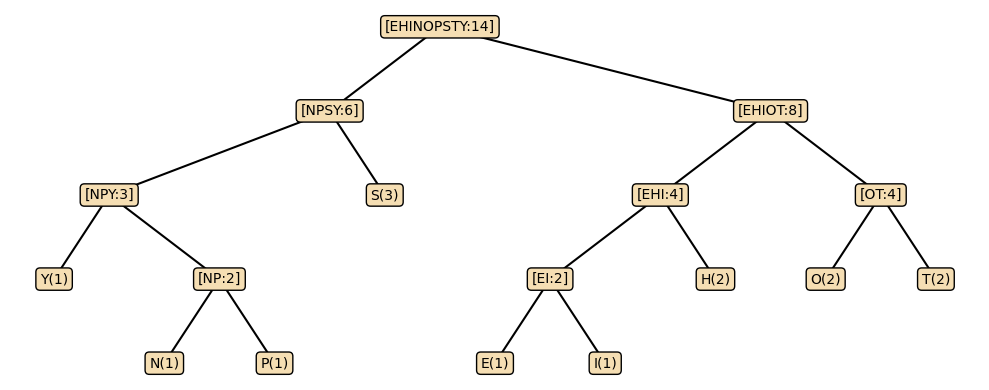

In [5]:
import matplotlib.pyplot as plt

def plot_tree(node):
    # assign x positions by inorder traversal
    xs = {}
    def inorder(n, x=0):
        if n is None:
            return x
        x = inorder(n.left, x)
        xs[n] = x
        x += 1
        x = inorder(n.right, x)
        return x
    inorder(node)
    ys = {}
    def set_y(n, depth=0):
        if n is None:
            return
        ys[n] = -depth
        set_y(n.left, depth+1)
        set_y(n.right, depth+1)
    set_y(node)
    fig, ax = plt.subplots(figsize=(10,4))
    for n in xs:
        ax.text(xs[n], ys[n], node_label(n), ha='center', va='center', bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='k'))
        if n.left:
            ax.plot([xs[n], xs[n.left]], [ys[n], ys[n.left]], 'k-')
        if n.right:
            ax.plot([xs[n], xs[n.right]], [ys[n], ys[n.right]], 'k-')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

try:
    plot_tree(tree)
except Exception as e:
    print('Plot skipped (matplotlib may not be available in this environment):', e)


## 6 — Reflection

I compressed the word **"PHOTOSYNTHESIS"** using Huffman coding. The algorithm gave short codes to the letters that appear most often (for example, **S**, and then **H**, **O**, and **T**) and longer codes to letters that appear only once. Because the word contains a mix of repeated letters and many singletons, Huffman coding produces a moderate but useful reduction in size. Importantly, the encoded bit stream only makes sense if the receiver knows the same tree (or an equivalent canonical representation), otherwise the variable-length codes are ambiguous. Overall, Huffman coding is a simple, effective method when some symbols repeat often; for streams or unknown distributions you'd consider adaptive or arithmetic coding.

*N.D:* I wrote this notebook to be clear and step-by-step. I used small helper functions and deterministic tie-breaking so results are reproducible.

## 7 — How to run this notebook

1. Run each cell from top to bottom (or choose Kernel → Restart & Run All).
2. If matplotlib fails to display the diagram, the rest of the calculations still work.
3. Replace `text = "PHOTOSYNTHESIS"` in the first code cell to test other words.
